# Corrupt input in switching RNN

In [1]:
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys
from numpy import linalg as LA


import argparse, os, math, pickle, json

# 1) Load your model
from dual_alm_rnn_models import *
from dual_alm_rnn_models import TwoHemiRNNTanh_asymmetric_single_readout
from dual_alm_rnn_exp import DualALMRNNExp
plt.rcParams['pdf.fonttype'] = '42' 


In [39]:
exp = DualALMRNNExp()

# Load configs to get model parameters
with open('dual_alm_rnn_configs.json', 'r') as f:
    configs = json.load(f)


exp.configs['train_type'] = "train_type_modular_corruption_fixed_input_cross_hemi_switch"
exp.configs['init_cross_hemi_rel_factor'] = 0.5
exp.configs['random_seed'] = 1
exp.configs['corruption_start_epoch'] = 30
exp.configs['n_epochs'] = 45
exp.configs['switch_ps'] = [0.7, 0.1, 0.1, 0.1]
exp.configs['corruption_noise'] = 0.5
exp.configs['one_hot'] = 1

model = getattr(sys.modules[__name__], configs['model_type'])(exp.configs, \
    exp.a, exp.pert_begin, exp.pert_end, noise=True)
# model = TwoHemiRNNTanh_single_readout(configs, exp.a, exp.pert_begin, exp.pert_end)
exp.init_sub_path(exp.configs['train_type'])

checkpoint_file = 'last_model.pth'
# checkpoint_file = 'model_epoch_25.pth'
checkpoint_path = os.path.join(exp.configs['models_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
print(checkpoint_path)
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)
# params = {'batch_size': configs['bs'], 'shuffle': True}
# inputs = data.TensorDataset(torch.tensor(sensory_inputs), torch.tensor(trial_type_labels))
# inputs = data.DataLoader(inputs, **params)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # CW Mac update
model = model.to(device)
model.eval()
# Draw the readout trajectory/
bias = model.readout_linear.bias.data.cpu().numpy()[0]
readout_weights = model.readout_linear.weight.data.cpu().numpy()
recurrent_weights = model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy()
input_weights = model.w_xh_linear_left_alm.weight.data.cpu().numpy()
recurrent_bias = model.rnn_cell.w_hh_linear_ll.bias.data.cpu().numpy()

# print(input_weights)
# plt.plot(model.rnn_cell.w_hh_linear_lr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())
# plt.plot(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())
print(np.sum(np.abs(model.rnn_cell.w_hh_linear_rr.weight.data.cpu().numpy())), np.sum(np.abs(model.rnn_cell.w_hh_linear_ll.weight.data.cpu().numpy())))
model.rnn_cell.w_hh_linear_rl.weight.data.cpu().numpy()

Fixed input weights for left and right ALM
dual_alm_rnn_models/TwoHemiRNNTanh_single_readout/train_type_modular_corruption_fixed_input_cross_hemi_switch/onehot_cor_type_gaussian_epoch_30_noise_0.50/n_neurons_256_random_seed_1/n_epochs_45_n_epochs_across_hemi_0/lr_1.0e-04_bs_256/sigma_input_noise_0.10_sigma_rec_noise_0.10/xs_left_alm_amp_1.00_right_alm_amp_1.00/init_cross_hemi_rel_factor_0.50/last_model.pth
823.59656 821.2145


array([[-0.04124047, -0.02057766,  0.01072306, ...,  0.02380569,
         0.01344305,  0.0176931 ],
       [ 0.01019214, -0.00580583,  0.03177292, ...,  0.01232127,
         0.01588304,  0.00178802],
       [ 0.04055698,  0.02739601,  0.01251321, ...,  0.03759558,
         0.04391385,  0.01217275],
       ...,
       [ 0.02274314, -0.03916375, -0.04426312, ..., -0.04594569,
        -0.01816696,  0.00470935],
       [-0.02538284,  0.01839505, -0.05074845, ..., -0.05781518,
         0.00728648,  0.04583161],
       [-0.03661961,  0.04202732, -0.00795324, ..., -0.00137773,
        -0.01163901, -0.03295865]], dtype=float32)

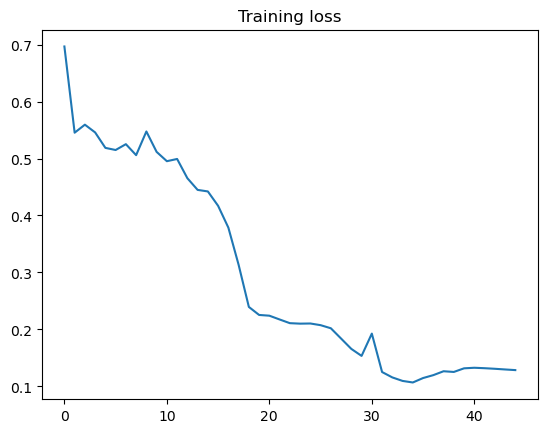

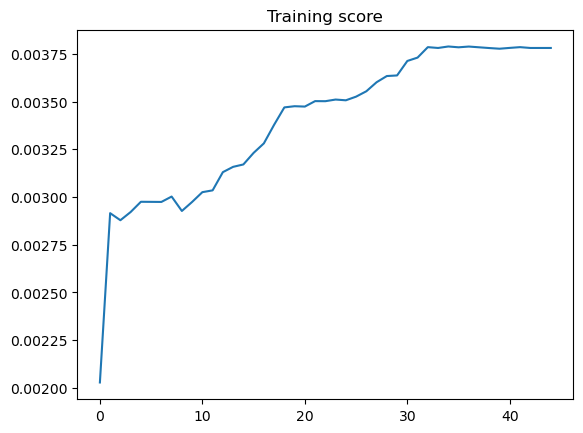

In [41]:
checkpoint_path = os.path.join(exp.configs['logs_dir'], exp.configs['model_type'], exp.sub_path, 'all_epoch_val_losses.npy')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")

all_epoch_train_losses = np.load(checkpoint_path)
all_epoch_train_scores = np.load(os.path.join(exp.configs['logs_dir'], exp.configs['model_type'], exp.sub_path, 'all_epoch_val_scores.npy'))
plt.plot(all_epoch_train_losses)
plt.title('Training loss')
plt.show()
plt.plot(all_epoch_train_scores)
plt.title('Training score')
plt.show()

## Plot example sensory input

In [ ]:
# Plot example sensory input



### Learning trajectory

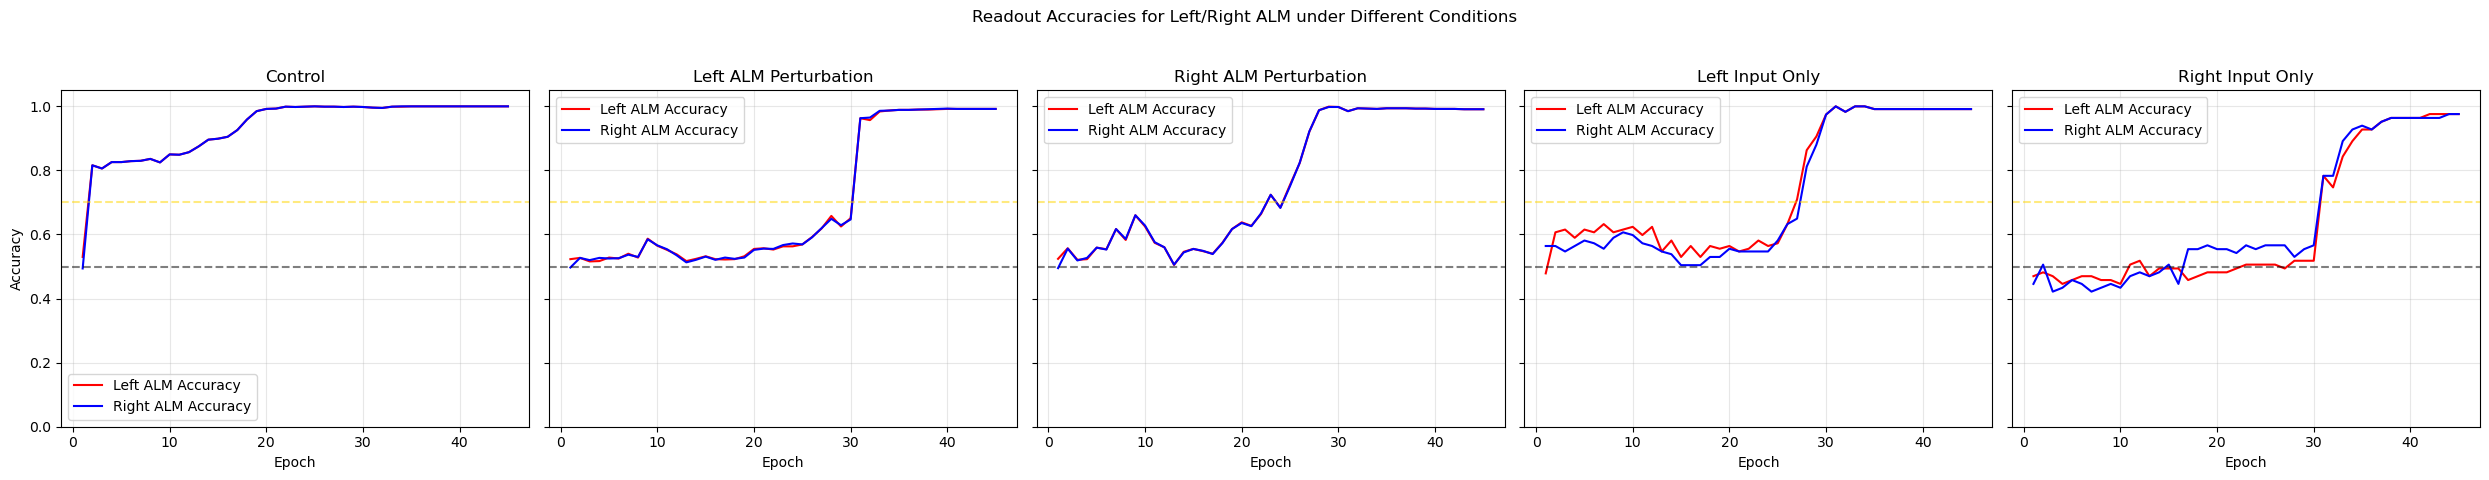

In [40]:

checkpoint_file = 'all_val_results_dict.npy'
checkpoint_path = os.path.join(exp.configs['logs_dir'], exp.configs['model_type'], exp.sub_path, checkpoint_file)

results_dict = np.load(checkpoint_path, allow_pickle=True)

epochs = np.arange(1, len(results_dict) + 1)
readout_acc_left = np.array([results_dict[i]['control']['readout_accuracy_left'] for i in range(len(results_dict))])
readout_acc_right = np.array([results_dict[i]['control']['readout_accuracy_right'] for i in range(len(results_dict))])
pert_left_readout_acc_left = np.array([results_dict[i]['left_alm_pert']['readout_accuracy_left'] for i in range(len(results_dict))])
pert_left_readout_acc_right = np.array([results_dict[i]['left_alm_pert']['readout_accuracy_right'] for i in range(len(results_dict))])
pert_right_readout_acc_left = np.array([results_dict[i]['right_alm_pert']['readout_accuracy_left'] for i in range(len(results_dict))])
pert_right_readout_acc_right = np.array([results_dict[i]['right_alm_pert']['readout_accuracy_right'] for i in range(len(results_dict))])
left_input_only_readout_acc_left = np.array([results_dict[i]['left_input_only']['readout_accuracy_left'] for i in range(len(results_dict))])
left_input_only_readout_acc_right = np.array([results_dict[i]['left_input_only']['readout_accuracy_right'] for i in range(len(results_dict))])
right_input_only_readout_acc_left = np.array([results_dict[i]['right_input_only']['readout_accuracy_left'] for i in range(len(results_dict))])
right_input_only_readout_acc_right = np.array([results_dict[i]['right_input_only']['readout_accuracy_right'] for i in range(len(results_dict))])
# time_to_reach.append(np.where(readout_acc_left > 0.9)[0][0])
# time_to_reach_right.append(np.where(readout_acc_right > 0.9)[0][0])


n_trials_agreed = np.array([results_dict[i]['control']['n_trials_agreed'] for i in range(len(results_dict))])
n_trials = np.array([results_dict[i]['control']['n_trials'] for i in range(len(results_dict))])
agreement_frac = n_trials_agreed / n_trials

# Compute chance level: p(agree) = p_L^2 + (1-p_L)^2 if p_L = p_R, but here use both
chance_agree = readout_acc_left * readout_acc_right + (1 - readout_acc_left) * (1 - readout_acc_right)

corruption_start_epoch = exp.configs['corruption_start_epoch']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,5, figsize=(25, 5), sharey=True)

conditions = [
    ('control', readout_acc_left, readout_acc_right),
    ('left_alm_pert', pert_left_readout_acc_left, pert_left_readout_acc_right),
    ('right_alm_pert', pert_right_readout_acc_left, pert_right_readout_acc_right),
    ('left_input_only', left_input_only_readout_acc_left, left_input_only_readout_acc_right),
    ('right_input_only', right_input_only_readout_acc_left, right_input_only_readout_acc_right),
]
condition_labels = ['Control', 'Left ALM Perturbation', 'Right ALM Perturbation', 'Left Input Only', 'Right Input Only']

epochs = np.arange(1, len(readout_acc_left) + 1)

for i, (cond_name, acc_left, acc_right) in enumerate(conditions):
    axes[i].plot(epochs, acc_left, color='red', label='Left ALM Accuracy')
    axes[i].plot(epochs, acc_right, color='blue', label='Right ALM Accuracy')
    axes[i].set_title(f'{condition_labels[i]}')
    axes[i].set_xlabel('Epoch')
    if i == 0:
        axes[i].set_ylabel('Accuracy')
    axes[i].set_ylim([0, 1.05])
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(0.5, color='black', linestyle='--', alpha=0.5)
    axes[i].axhline(0.7, color='gold', linestyle='--', alpha=0.5)
    axes[i].legend()

plt.suptitle('Readout Accuracies for Left/Right ALM under Different Conditions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Plot example dynamics

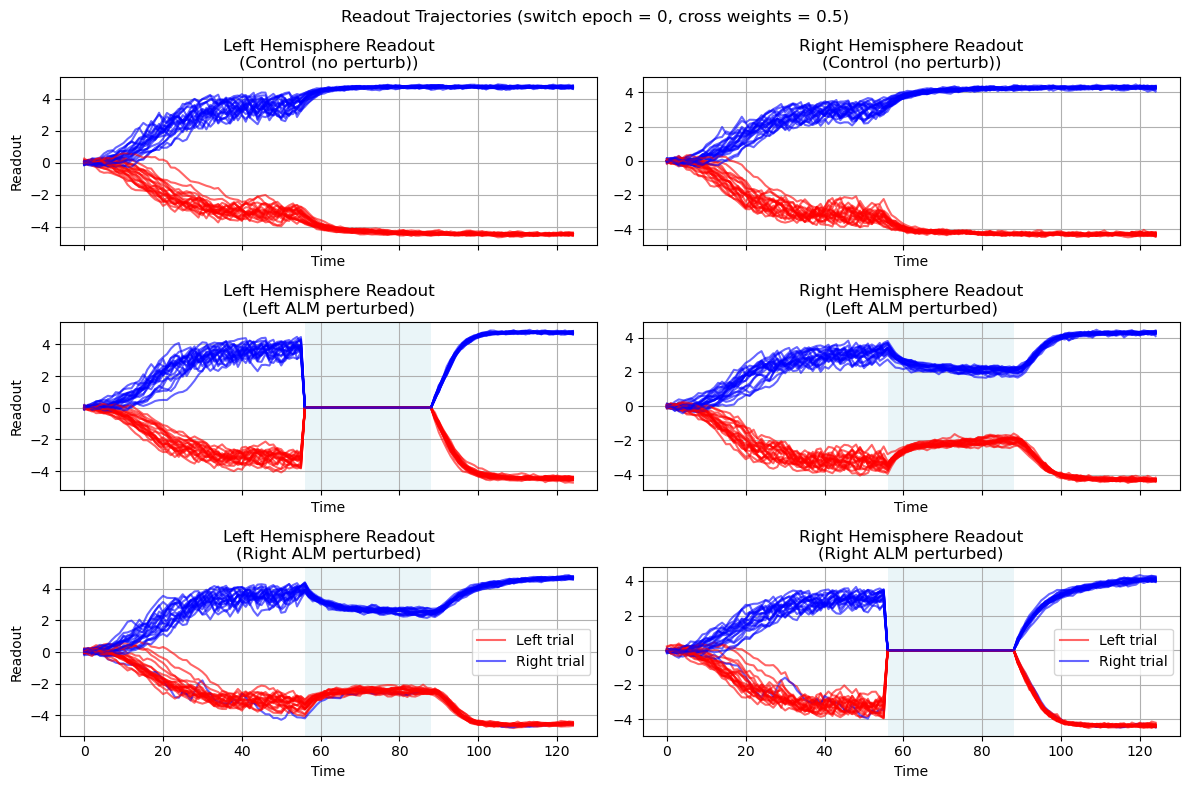

In [38]:
# Plot what happens to individual readouts on control vs perturbation trials
import matplotlib.gridspec as gridspec

# start by loading data
train_save_path = os.path.join(exp.configs['data_dir'], 'train')

train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs_same_noise.npy' ))
train_sensory_inputs = np.load(os.path.join(train_save_path, 'onehot_sensory_inputs.npy' ))
train_trial_type_labels = np.load(os.path.join(train_save_path, 'onehot_trial_type_labels.npy'))
# load train inputs and labels

train_sensory_inputs.shape, train_trial_type_labels.shape

l_trial_idx = np.where(train_trial_type_labels == 0)[0]
r_trial_idx = np.where(train_trial_type_labels == 1)[0]

l_trial_input = train_sensory_inputs[l_trial_idx, :]
r_trial_input = train_sensory_inputs[r_trial_idx, :]

l_trial_input = torch.tensor(l_trial_input).to(device)
r_trial_input = torch.tensor(r_trial_input).to(device)
l_trial_input.shape

sample_begin = exp.sample_begin
delay_begin = exp.delay_begin
l_trial_input_all, r_trial_input_all = l_trial_input, r_trial_input


### After data loading, run model # with no noise:
model.train_type = "train_type_modular_fixed_input_cross_hemi"
model.corrupt = False
model.return_input = True


# Pass input into model
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)  # 3 conditions, 2 hemispheres

# Define condition names for labeling
condition_names = [
    "Control (no perturb)", 
    "Left ALM perturbed", 
    "Right ALM perturbed"
]
# For legend management
line_objs = [[None, None] for _ in range(3)]

# For each of the three conditions: control, left alm pert, right alm pert
for rowidx, (uni_pert, left_pert) in enumerate([
        (0.0, 0.5),   # Control: no perturb
        (1.0, 1.0),   # Left ALM perturbed
        (1.0, 0.0)    # Right ALM perturbed
    ]):

    # Set model perturbation parameters for condition
    model.uni_pert_trials_prob = uni_pert
    model.left_alm_pert_prob = left_pert
    _, hs_l, zs_l = model(l_trial_input_all)    # left trial
    _, hs_r, zs_r = model(r_trial_input_all)    # right trial

    for i in range(20):
        # l_trial_input = l_trial_input_all[i].reshape(1, exp.T, 2)
        # r_trial_input = r_trial_input_all[i].reshape(1, exp.T, 2)

        # Compute left and right readouts for left and right trials
        left_readout_l = hs_l[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_l = hs_l[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        left_readout_r = hs_r[i, :, :model.n_neurons//2].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, :model.n_neurons//2]
        )
        right_readout_r = hs_r[i, :, model.n_neurons//2:].detach().cpu().numpy().dot(
            model.readout_linear.weight.data.cpu().numpy()[0, model.n_neurons//2:]
        )

        # Left hemisphere readout subplot (col 0)
        l_line = axs[rowidx,0].plot(left_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line = axs[rowidx,0].plot(left_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][0] = (l_line[0], r_line[0])

        # Right hemisphere readout subplot (col 1)
        l_line2 = axs[rowidx,1].plot(right_readout_l.flatten(), color='red', alpha=0.6, label='Left trial' if i==0 else None)
        r_line2 = axs[rowidx,1].plot(right_readout_r.flatten(), color='blue', alpha=0.6, label='Right trial' if i==0 else None)
        if i == 0: line_objs[rowidx][1] = (l_line2[0], r_line2[0])

    # Add light blue bar (span) for perturbation period on perturbation subplots
    # Only add for perturbed conditions (rowidx 1 and 2)
    if rowidx in [1, 2]:
        # perturbation likely in delay epoch; use exp.delay_begin, exp.T for x-range
        axs[rowidx,0].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)
        axs[rowidx,1].axvspan(exp.delay_begin, exp.pert_end, facecolor='lightblue', alpha=0.25, zorder=0)

    # Titles, labels for each row
    axs[rowidx,0].set_title(f"Left Hemisphere Readout\n({condition_names[rowidx]})" )
    axs[rowidx,1].set_title(f"Right Hemisphere Readout\n({condition_names[rowidx]})")
    axs[rowidx,0].set_ylabel("Readout")
    axs[rowidx,0].set_xlabel("Time")
    axs[rowidx,1].set_xlabel("Time")
    axs[rowidx,0].grid()
    axs[rowidx,1].grid()

# Only show legend in the bottom row for both hemispheres (col 0/col 1)
for col in range(2):
    axs[-1,col].legend()

plt.suptitle(f'Readout Trajectories (switch epoch = {exp.configs["switch_epoch_n"]}, cross weights = {exp.configs["init_cross_hemi_rel_factor"]})')
plt.tight_layout()
plt.show()




## Compare the modularity of the hemispheres when corruption is added at different epochs